<a href="https://colab.research.google.com/github/mipula/Projeto-Integrado-IV/blob/main/PI_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregar Bibliotecas

In [210]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, RocCurveDisplay
%matplotlib inline

In [100]:
!pip install sweetviz
import sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Carrega Dataset

In [101]:
#Mintel
from google.colab import files
uploaded = files.upload()

Saving Video_Games_Sales_as_at_22_Dec_2016.csv to Video_Games_Sales_as_at_22_Dec_2016 (2).csv


In [102]:
filename = next(iter(uploaded))

In [138]:
data = '/content/'+filename
df = pd.read_csv(data)
pd.options.display.max_columns = None
df.head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


#Analise Descritiva Inicial

In [104]:
eda=sweetviz.analyze(df)
eda.show_html()

/usr/local/lib/python3.10/dist-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/usr/local/lib/python3.10/dist-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/usr/local/lib/python3.10/dist-packa

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## DataFrame com User Score

In [139]:
# Apaga User_Score igual a 'TBD', define coluna como Float e Multiplica por 10 para estar na mesma ordem de grandeza de Critics Score
df_user = df.copy()
df_user = df_user[df_user['User_Score'].str.contains('tbd')==False]
df_user['User_Score'] = df_user['User_Score'].astype(float)
df_user['User_Score'] = df_user['User_Score']*10

<ipython-input-139-321a05adfc8b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['User_Score'] = df_user['User_Score'].astype(float)
<ipython-input-139-321a05adfc8b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['User_Score'] = df_user['User_Score']*10


In [151]:
col = ['Genre', 'Publisher','Global_Sales','User_Score']
df_user = df_user[col].dropna()
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7584 entries, 0 to 16709
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Genre         7584 non-null   object 
 1   Publisher     7584 non-null   object 
 2   Global_Sales  7584 non-null   float64
 3   User_Score    7584 non-null   float64
dtypes: float64(2), object(2)
memory usage: 296.2+ KB


## DataFrame com Critics Score

In [145]:
df_critic = df.copy()

In [150]:
col = ['Genre', 'Publisher','Global_Sales','Critic_Score']
df_critic = df_critic[col].dropna()
df_critic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8133 entries, 0 to 16709
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Genre         8133 non-null   object 
 1   Publisher     8133 non-null   object 
 2   Global_Sales  8133 non-null   float64
 3   Critic_Score  8133 non-null   float64
dtypes: float64(2), object(2)
memory usage: 317.7+ KB


# Funções

In [109]:
#Define função que agrupa score
def score_group(score):
    if score >= 90:
        return '90-100'
    elif score >= 80:
        return '80-89'
    elif score >= 70:
        return '70-79'
    elif score >= 60:
        return '60-69'
    elif score >= 50:
        return '50-59'
    else:
        return '0-49'

In [110]:
def in_top(x):
    if x in pack:
        return x
    else:
        pass
def width(x):
    if x == 'Publisher':
        return 11.3
    elif x == 'Genre':
        return 13.6

def height(x):
    if x == 'Genre':
        return 8
    else:
        return 9

# Montar Gráfico de Calor

In [111]:
#Agrupa Score
df['Score_Group'] = df['Critic_Score'].apply(lambda x: score_group(x))

<ipython-input-112-1bf4efd1c3d1>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_platform = df[[col, 'Score_Group', 'Global_Sales']].groupby([col, 'Score_Group']).median().reset_index().pivot(col,
<ipython-input-112-1bf4efd1c3d1>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_platform = df[[col, 'Score_Group', 'Global_Sales']].groupby([col, 'Score_Group']).median().reset_index().pivot(col,


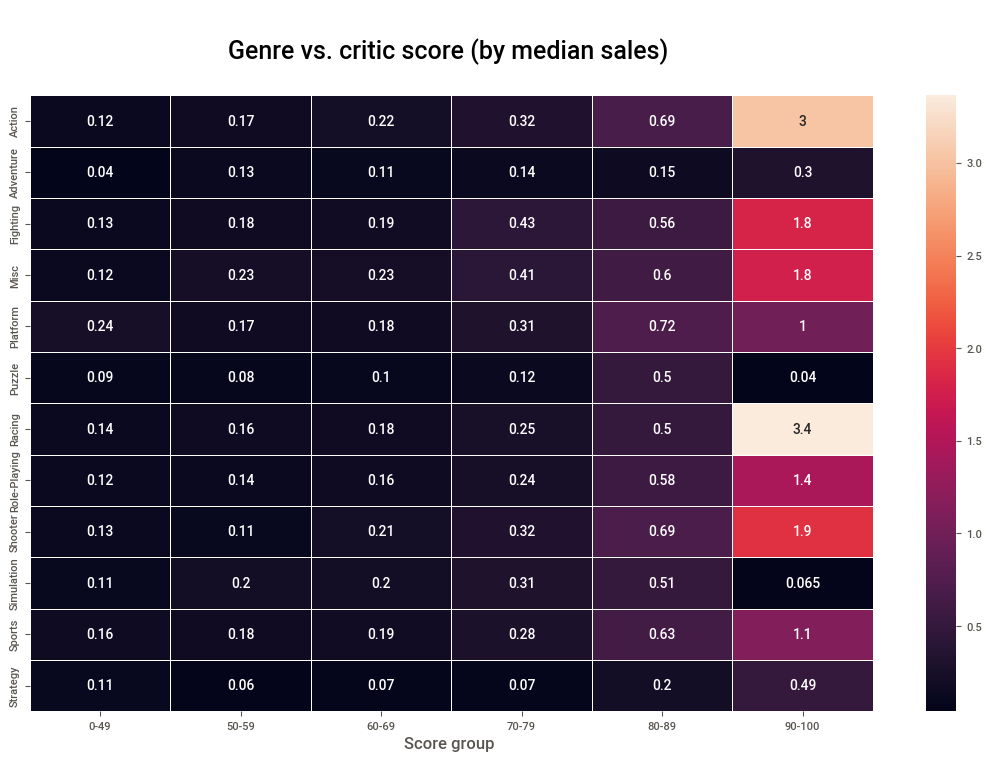

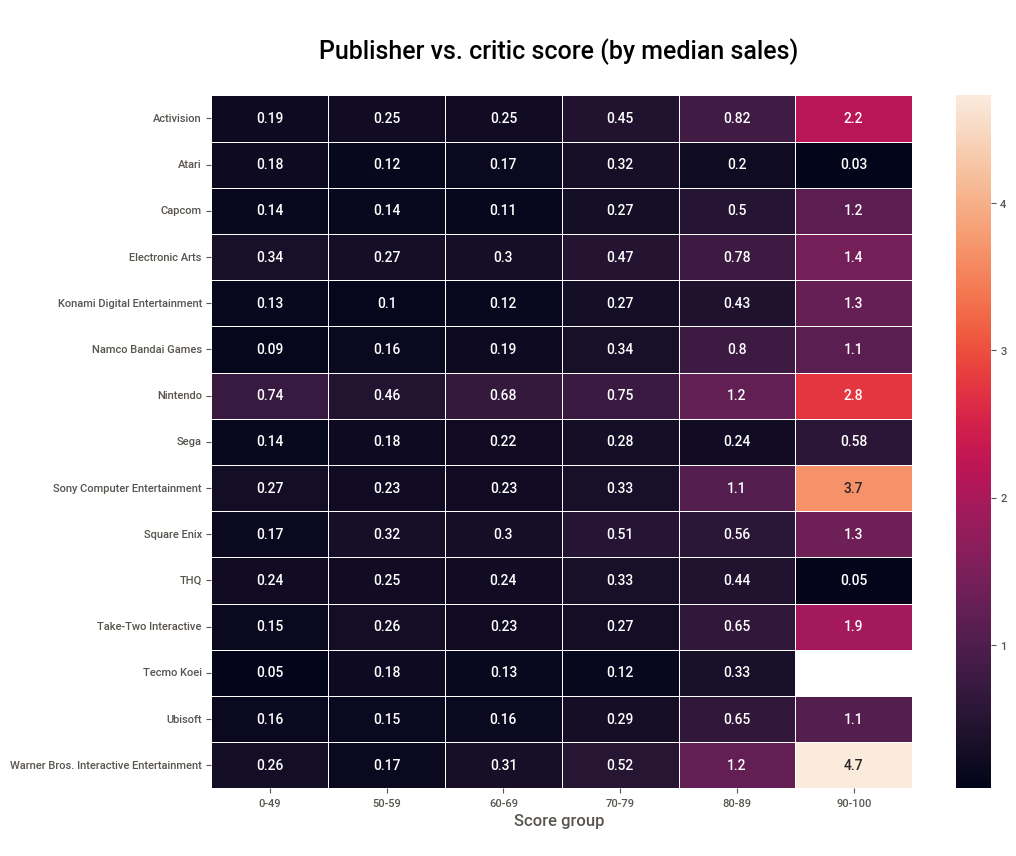

In [112]:
cols = ['Genre', 'Publisher']
for col in cols:
    pack = []
    top = df[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()[:15]
    for x in top[col]:
        pack.append(x)
    df[col] = df[col].apply(lambda x: in_top(x))
    df_platform = df[[col, 'Score_Group', 'Global_Sales']].groupby([col, 'Score_Group']).median().reset_index().pivot(col, 
                                                                                                          "Score_Group", "Global_Sales")
    plt.figure(figsize=(width(col), height(col)))
    sns.heatmap(df_platform, annot=True, fmt=".2g", linewidths=.5).set_title((' \n'+col+' vs. critic score (by median sales) \n'), 
                                                                             fontsize=18)
    plt.ylabel('', fontsize=14)
    plt.xlabel('Score group \n', fontsize=12)
    pack = []

# Aplicação Modelos Machine Learning Para CRITIC_SCORE 

In [173]:
#Define Variaveis Dependentes
var_dependente=['Genre', 'Publisher','Global_Sales']

In [174]:
#Transforma o que é Object (string) em Numero
df_critic[df_critic.select_dtypes(['object']).columns] = df_critic[df_critic.select_dtypes(['object']).columns].apply(lambda x: pd.factorize(x)[0])

In [193]:
atributos=df_critic[var_dependente]

In [194]:
classe = df_critic['Critic_Score']

In [203]:
#Separando os atributos dos rótulos e separando os dados de treinamento (90%) e teste (10%)
atributo_treino, atributo_teste, classes_treino, classes_teste = train_test_split(atributos, classe, test_size = 0.1)

In [204]:
#Diminuindo a escala de dados para melhorar treinamento
scaler = StandardScaler()
treino = scaler.fit_transform(atributo_treino)
teste = scaler.transform(atributo_teste)

## Vizinhos Mais Proximos KNN

In [205]:
from sklearn.neighbors import  KNeighborsClassifier

In [228]:
modelo_kNN = KNeighborsClassifier(n_neighbors = 5)
modelo_kNN.fit(atributo_treino, classes_treino)

KNeighborsClassifier()

In [229]:
#Verificando a Acurácia
predicao_kNN = modelo_kNN.predict(atributo_teste)
acuracia_kNN = accuracy_score(classes_teste, predicao_kNN)
print('Acurácia de classificação k-NN: {}'.format(round(acuracia_kNN, 3)*100)+'%')

Acurácia de classificação k-NN: 3.8%


In [230]:
print(classification_report(classes_teste, predicao_kNN))

              precision    recall  f1-score   support

        13.0       0.00      0.00      0.00         0
        17.0       0.00      0.00      0.00         0
        19.0       0.00      0.00      0.00         0
        20.0       0.00      0.00      0.00         2
        22.0       0.00      0.00      0.00         0
        23.0       0.00      0.00      0.00         0
        24.0       0.00      0.00      0.00         2
        25.0       0.00      0.00      0.00         1
        26.0       0.00      0.00      0.00         2
        27.0       0.00      0.00      0.00         2
        28.0       0.00      0.00      0.00         1
        30.0       0.00      0.00      0.00         0
        31.0       0.00      0.00      0.00         0
        32.0       0.00      0.00      0.00         2
        33.0       0.11      0.33      0.17         3
        34.0       0.00      0.00      0.00         0
        35.0       0.00      0.00      0.00         1
        36.0       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

## Agrupamento usando Maquina de Vetores de Suporte

In [233]:
from sklearn.svm import SVC

In [ ]:
modelo_SVM = SVC(kernel = 'linear')
modelo_SVM.fit(atributo_treino, classes_treino)

In [ ]:
# Acurácia de classificação com SVM
predicao_SVM = modelo_SVM.predict(atributo_teste)
acuracia_SVM = accuracy_score(classes_teste, predicao_SVM)
print('Acurácia de classificação SVM: {}'.format(round(acuracia_SVM,3)*100)+'%')

In [ ]:
#Precisão, revogação e medida F1
print(classification_report(classes_teste, predicao_SVM))

## Agrupamento usando

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
modelo_RF = RandomForestClassifier()
modelo_RF.fit(vinhos_treino, classes_treino)

In [ ]:
predicao_RF = modelo_RF.predict(vinhos_teste)
acuracia_RF = accuracy_score(classes_teste, predicao_RF)
print('Acurácia de classificação RF: {}'.format(round(acuracia_RF,3)*100)+'%')

In [ ]:
print(classification_report(classes_teste, predicao_RF))

## Agrupamento hierárquico

In [171]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
plt.rcParams["figure.figsize"] = (15,10)

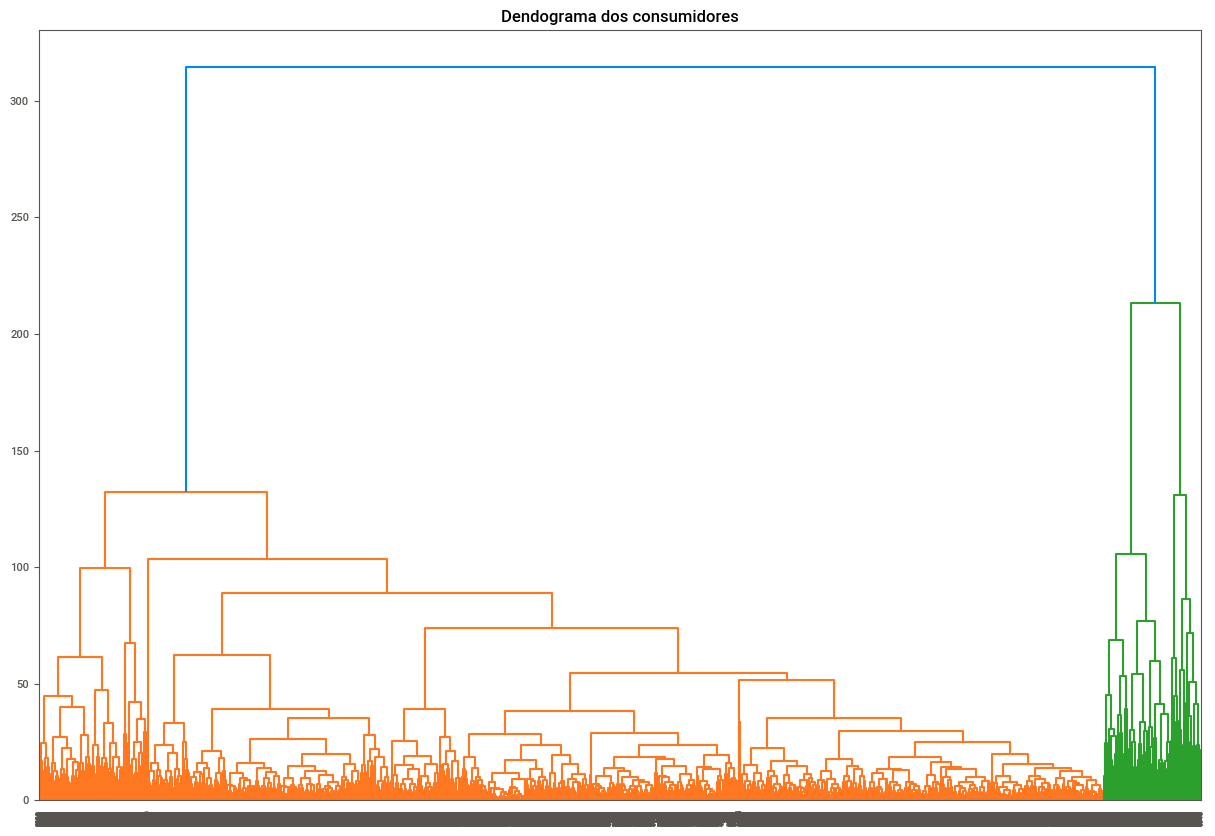

In [178]:
plt.title("Dendograma Do Score Critico")
dendograma = shc.dendrogram(shc.linkage(df_critic, method='complete'))

In [188]:
n_grupos = 3
grupos = AgglomerativeClustering(n_clusters=n_grupos, metric='euclidean', linkage='complete')
grupos.fit_predict(df_critic)

array([0, 0, 0, ..., 0, 0, 2])

In [189]:
from sklearn.decomposition import PCA

In [191]:
pca = PCA(n_components=2).fit(grupos.toarray())
pca_2d = pca.transform(grupos.toarray())
pca_2d

AttributeError: ignored

In [190]:
import pylab as pl
pl.figure('FIGURA1')
for i in range(0, pca_2d.shape[0]):
  if kmeans.labels_[i] == 0:
    cl = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r', marker='+')
  elif kmeans.labels_[i] == 1:
    c = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g', marker='o')
  elif kmeans.labels_[i] == 2:
    c = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b', marker='*')
#  elif kmeans.labels_[i] == 3:
#    c = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='k', marker='x')
pl.title('Titulo')
pl.show() 

NameError: ignored

<Figure size 1500x1000 with 0 Axes>